In [2]:
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import sklearn
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
import latexify as lt
import os
#from thinkdsp import read_json
import scipy
import speechpy
#LOSO Validation
loo = LeaveOneOut()
import tsfel
#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;
import pickle

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [2]:
#the file where all data is arranged.
dataC = pd.read_csv("data_FVC_Cloth.csv")
dataN = pd.read_csv("data_FVC_N95.csv")
print("Total Data Points = ",len(dataC))
print("Total Data Points = ",len(dataN))


Total Data Points =  25
Total Data Points =  24


In [3]:
#load time series feature
with open('ts-fel-cloth.pickle', 'rb') as handle:
    ts_features = pickle.load(handle)
    
with open('ts-fel-cloth-Envelope.pickle', 'rb') as handle:
    ts_features_envelope = pickle.load(handle)

In [4]:
def get_features(filepath, lungParam):
    
    #use the below line if the data is in json
    #wave = read_json(filepath=filepath)
    
    #use the below line if the data is in wav
    ys, fs = librosa.load(filepath)
    
    if lungParam == 'FEV1':
        #print("FEV1 is the param. Audio signal will be clipped to peak only")
        peakIndex = np.where(ys == ys.max())[0][0]
        ys = ys[0:peakIndex+1];

    ys = speechpy.processing.preemphasis(ys, cof=0.98)
    
    
    #staching frames
    frames = speechpy.processing.stack_frames(ys, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01, filter=lambda x: np.ones((x,)),zero_padding=True)

    '''
    *MFCC*
    We calculate the mean value for every single coefficient for MFCC. It means that for every audio file
    we have a vector of size 13 elements (For MFCC with 13 coefficients).
    
    *MelSpectogram*
    We calculate the mean value for every single mel band. It means that for every audio file
    we have a vector of size 128 elements (For 128 Mel bands).
    
    *Chromagram*
    12 Chroma Bins are produced by default. Similar to above, we  have a vector of size 12 for each audio file
    
    '''
    
   
    #speechfy features begins
    #extracting power spectrum
    power_spectrum = np.mean(speechpy.processing.power_spectrum(frames, fft_points=512), axis=0)
    #print(power_spectrum.shape)
    
    mfcc = speechpy.feature.mfcc(ys, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01,
             num_filters=40, fft_length=512, low_frequency=0, high_frequency=None)
    mfcc_cmvn = np.mean(speechpy.processing.cmvnw(mfcc,win_size=301,variance_normalization=True), axis=0)
    
    logenergy = speechpy.feature.lmfe(ys, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01,
             num_filters=40, fft_length=512, low_frequency=0, high_frequency=None)
    #logenergy_feature_cube = np.mean(speechpy.feature.extract_derivative_feature(logenergy), axis=0)
    logenergy = np.mean(logenergy, axis=0)
    
    mfe = speechpy.feature.mfe(ys, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01,
             num_filters=40, fft_length=512, low_frequency=0, high_frequency=None)
    mfe = np.mean(mfe[0],axis=0)
    
    
    #librosa feature begins
    stat_features = ts_features[filepath.split('/')[-1]]
    stat_features_envelope = ts_features_envelope[filepath.split('/')[-1]]
    
    mfc_coefficients = np.mean(librosa.feature.mfcc(y=ys, n_mfcc=13, sr=16000),axis=1)
    #print(mfc_coefficients.shape)
    
    
    melspectogram = np.mean(librosa.feature.melspectrogram(y=ys, sr=16000, n_mels=64, fmax=8000),axis=1)
    #print(melspectogram.shape)
    
    stft_spectrogram=np.abs(librosa.stft(ys))
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=16000),axis=1)
    
    
    S, phase = librosa.magphase(librosa.stft(ys))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(S=S, sr=fs), axis=1) 
    zcr = np.mean(librosa.feature.zero_crossing_rate(ys)[0])
    
    
    '''
    We now have a vector of size 818 in the feature matrix. Later, we also add the approximate
    value of respective
    #lung parameter which changes the size of the vector to 154
    '''
    #feature_matrix_r = np.hstack((mfc_coefficients,melspectogram))
    #feature_matrix_r = np.hstack((melspectogram))
    feature_matrix_r = np.hstack((stat_features,stat_features_envelope,mfe, logenergy, mfcc_cmvn,power_spectrum,melspectogram,chromagram,spectral_rolloff,zcr))
    
    '''
    print("Stat Features = ",stat_features.shape)
    print("Stat Features (Envelope) = ",stat_features_envelope.shape)
    print("MFE Features = ",mfe.shape)
    print("Log Energy Features = ",logenergy.shape)
    print("MFCC CMVN Features = ",mfcc_cmvn.shape)
    print("Power Spectrum Features = ",power_spectrum.shape)
    print("Melspectogram Features = ",melspectogram.shape)
    print("Chroma Features = ",chromagram.shape)
    print("Spectral Roll Off  = ",spectral_rolloff.shape)
    print("ZCR Features = ", zcr.shape)
    '''
    
    #feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))
    
    #add the estimated param as a feature
    #feature_matrix = np.hstack((feature_matrix_r, FEV1values))
    return feature_matrix_r


def load_data(lungParam, sex, LH, file):
    '''
    feature: it is either 'FEV1', 'FVC' or 'PEF'
    '''
    data = pd.read_csv(file)
    
    if sex == 'M' or sex == 'F':
        data = data[data['Sex'] == sex]
    if LH == 'Y' or LH == 'N':
        data = data[data['LH'] == LH]
    
    
    #get the ground truth
    y=  np.array([i for i in data['g'+lungParam]])
    
    #prepare to store a lot of features in X
    X=[]
    count = 0
    for file in data['Filename']:
        features = get_features("SpiroMask-July2021/SmartMaskData/FVC/Cloth/"+file, lungParam)
        #print("Size of features = ",features.shape)
        X.append(features)
        count += 1
    X =  np.array(X)
    
    
    #add the estiamted lung param as a feature
    estiamtedValues = np.atleast_2d(data['r'+lungParam].to_numpy()).T
    X = np.hstack((X, estiamtedValues))
    # Return arrays to plug into sklearn's cross-validation algorithms
    return X, np.array(y)

## Using The Best Hyperparameters For FVC

In [ ]:
#compare with base model
#ML inits
#regressor = RandomForestRegressor(n_estimators = 5000, random_state = 0, )
#regressor = SVR(kernel = 'rbf', C=0.1, gamma='auto')
#regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.5,max_depth = 50, alpha = 10, n_estimators = 50)
#regressor = Lasso(alpha = 0.01)
#regressor = Ridge(alpha=0.01)
#regressor = LinearRegression()
#regressor = BaggingRegressor(base_estimator=RandomForestRegressor(), n_estimators=10000, n_jobs=-1)
regressor = RandomForestRegressor(bootstrap=False, criterion='mae', n_estimators=10000, min_samples_split=0.1, 
                                  min_samples_leaf=0.1, max_features='sqrt', max_depth=None)

#load_data(param, Sex, Lung issue?)
X, Y = load_data('PEF', 'A', 'Y', "data_FVC_Cloth.csv")
loo.get_n_splits(X)


print("Getting the performence of base model")
#base = RandomForestRegressor(criterion='mae', n_estimators = 10, random_state = 42)
#print("\n\n****Running Regression on PEF****")
min_pe= 0.99 
pe=[]
for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    #for RF and SVR
    reg = regressor.fit(X_train, y_train)
    #reg = base.fit(X_train, y_train)
    #reg = LinearRegression().fit(X_train, y_train)
    #print("Learned coef is = ",reg.coef_[0])
    #print("Learned intercept is = ",reg.intercept_)
    print("Predicted= ", reg.predict(X_test)[0])
    print("True = ", y_test[0])
    #trueValue.append(y_test)
    #predictedValue.append(reg.predict(X_test))
    #print("Sample Error = ",np.abs((y_test-reg.predict(X_test))/y_test))
    #mse = mse+mean_squared_error(reg.predict(X_test), y_test)
    pe.append(np.abs((y_test-reg.predict(X_test))/y_test))
    #if np.abs((y_test-reg.predict(X_test))/y_test) < min_pe:
    #    min_pe = np.abs((y_test-reg.predict(X_test))/y_test)
print("PE Mean = ", np.mean(pe));
print("PE STD = ", np.std(pe))


'''
trueValue = []
predictedValue = []

print("\n\nGetting the performence of best random model")
regressor = RandomForestRegressor(bootstrap=False, criterion='mae', n_estimators=10000, min_samples_split=2, min_samples_leaf=5, max_features='auto', max_depth=100)
#print("\n\n****Running Regression on PEF****")
min_pe= 0.99 
pe=[]
for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    #for RF and SVR
    reg = regressor.fit(X_train, y_train)
    
    #reg = LinearRegression().fit(X_train, y_train)
    #print("Learned coef is = ",reg.coef_[0])
    #print("Learned intercept is = ",reg.intercept_)
    print("Predicted= ", reg.predict(X_test)[0])
    print("True = ", y_test[0])
    trueValue.append(y_test[0])
    predictedValue.append(reg.predict(X_test)[0])
    #print("Sample Error = ",np.abs((y_test-reg.predict(X_test))/y_test))
    #mse = mse+mean_squared_error(reg.predict(X_test), y_test)
    pe.append(np.abs((y_test-reg.predict(X_test))/y_test))
    #if np.abs((y_test-reg.predict(X_test))/y_test) < min_pe:
    #    min_pe = np.abs((y_test-reg.predict(X_test))/y_test)
print("PE Mean = ", np.mean(pe));
print("PE STD = ", np.std(pe))
pd.DataFrame({'True':trueValue, 'Predicted':predictedValue}).to_csv("result-FEV1-Cloth-Not-Healthy.csv")
'''

528 116383 441 220.0
583 128624 441 220.0
720 158659 441 220.0
752 165677 441 220.0
746 164371 441 220.0
791 174328 441 220.0
651 143641 441 220.0
579 127645 441 220.0
820 180693 441 220.0
737 162413 441 220.0
501 110514 441 220.0
479 105699 441 220.0
428 94504 441 220.0
794 174981 441 220.0
789 173839 441 220.0
523 115330 441 220.0
541 119255 441 220.0
766 168778 441 220.0
651 143478 441 220.0
Getting the performence of base model
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [0]
Predicted=  5.415260200000001
True =  4.39
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [1]
Predicted=  5.317892199999998
True =  7.0
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [2]
Predicted=  5.4046741
True =  4.5
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [3]
Predicted=  5.6263729000000025
True =  7.12
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [4]
Predicted=  6.0604515
True =  7.81
T

In [21]:
'''
0-389: Stat Features
390-779: Stat Features From Envelope
780-819: MFE Features
820-859: Log Energy Features
860-872: MFCC CMVN Features
873-1129: Power Spectrum Features (257)
1130-1193: Melspectogram Features (64)
1194-1205: Chroma Features (12)
1206-1206: Spectral Roll off
1207-1207: ZCR
'''
for param in ['PEF', 'FEV1', 'FVC']:
    X, Y = load_data(param, 'A', 'A', "data_FVC_Cloth.csv")

    loo.get_n_splits(X)
    feature_names = [f'feature {i}' for i in range(X.shape[1])]
    
    if param == 'PEF':
        avg_feat_importances_PEF = pd.Series(np.zeros(len(feature_names)), index=feature_names)
    elif param == 'FEV1':
        avg_feat_importances_FEV1 = pd.Series(np.zeros(len(feature_names)), index=feature_names)
    elif param == 'FVC':
        avg_feat_importances_FVC = pd.Series(np.zeros(len(feature_names)), index=feature_names)
    
    regressor = RandomForestRegressor(bootstrap=False, criterion='mae', n_estimators=100, min_samples_split=2, min_samples_leaf=5, max_features='auto', max_depth=100)
    count=0;
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        #for RF and SVR
        reg = regressor.fit(X_train, y_train)
        importances = reg.feature_importances_
        feat_importances = pd.Series(importances, index=feature_names)
        
        if param == 'PEF':
            avg_feat_importances_PEF = avg_feat_importances_PEF.add(feat_importances)
           
        elif param == 'FEV1':
            avg_feat_importances_FEV1 = avg_feat_importances_FEV1.add(feat_importances)
            
        elif param == 'FVC':
            avg_feat_importances_FVC = avg_feat_importances_FVC.add(feat_importances)
            
        
        count+=1;
        #feat_importances.nlargest(10).plot(kind='barh', figsize=(5,10))
        #plt.show()

        
    if param == 'PEF':
        avg_feat_importances_PEF = avg_feat_importances_PEF.divide(other=count)
    elif param == 'FEV1':
        avg_feat_importances_FEV1 = avg_feat_importances_FEV1.divide(other=count)
    elif param == 'FVC':
        avg_feat_importances_FVC = avg_feat_importances_FVC.divide(other=count)

#feat_importances = pd.Series(importances, index=feature_names)


528 116383 441 220.0
583 128624 441 220.0
720 158659 441 220.0
752 165677 441 220.0
746 164371 441 220.0
791 174328 441 220.0
651 143641 441 220.0
579 127645 441 220.0
820 180693 441 220.0
737 162413 441 220.0
535 117934 441 220.0
382 84321 441 220.0
681 150085 441 220.0
501 110514 441 220.0
479 105699 441 220.0
428 94504 441 220.0
794 174981 441 220.0
789 173839 441 220.0
1027 226347 441 220.0
523 115330 441 220.0
523 115330 441 220.0
411 90756 441 220.0
541 119255 441 220.0
766 168778 441 220.0
651 143478 441 220.0
122 27221 441 220.0
156 34671 441 220.0
136 30271 441 220.0
139 30862 441 220.0
122 27155 441 220.0
117 26040 441 220.0
133 29645 441 220.0
115 25628 441 220.0
121 26882 441 220.0
129 28730 441 220.0
130 28922 441 220.0
124 27626 441 220.0
203 45017 441 220.0
182 40403 441 220.0
213 47288 441 220.0
179 39819 441 220.0
138 30749 441 220.0
133 29674 441 220.0
113 25131 441 220.0
134 29739 441 220.0
123 27370 441 220.0
140 31215 441 220.0
147 32695 441 220.0
136 30180 441 220

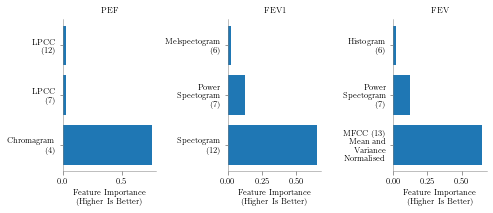

In [53]:
fig, ax = plt.subplots(1,3)
lt.latexify(columns=2, fig_height=3.0)
'''
ax[0].bar(avg_feat_importances_PEF.nlargest(3).index, avg_feat_importances_PEF.nlargest(3).values)
ax[0].set_ylim([0,1])
ax[1].bar(avg_feat_importances_FEV1.nlargest(3).index, avg_feat_importances_FEV1.nlargest(3).values)
ax[1].set_ylim([0,1])
ax[2].bar(avg_feat_importances_FVC.nlargest(3).index, avg_feat_importances_FVC.nlargest(3).values)
ax[2].set_ylim([0,1])
'''
ax[0].barh(['Chromagram \n(4)', 'LPCC \n(7)', 'LPCC \n(12)'], avg_feat_importances_PEF.nlargest(3).values)
ax[0].set_title('PEF')
ax[0].set_xlabel('Feature Importance \n(Higher Is Better)')
lt.format_axes(ax[0])
ax[1].barh(['Spectogram \n(12)', 'Power \nSpectogram \n(7)', 'Melspectogram \n(6)'], avg_feat_importances_FEV1.nlargest(3).values)
ax[1].set_title('FEV1')
ax[1].set_xlabel('Feature Importance \n(Higher Is Better)')
lt.format_axes(ax[1])
ax[2].barh(['MFCC (13) \nMean and \nVariance\n Normalised', 'Power\nSpectogram \n(7)', 'Histogram \n(6)'], avg_feat_importances_FEV1.nlargest(3).values)
ax[2].set_title('FEV')
ax[2].set_xlabel('Feature Importance \n(Higher Is Better)')
lt.format_axes(ax[2])
plt.tight_layout()
#plt.savefig("feature_importance.pdf", bbox_inches='tight')


In [20]:
[importances]

[array([0., 0., 0., ..., 0., 0., 0.])]

In [7]:
#Feature Investigation
ys, fs = librosa.load('SpiroMask-July2021/SmartMaskData/FVC/Cloth/Alok01.FVC_C.2blkl0aa.wav')
librosa.feature.melspectrogram(y=ys, sr=16000, n_mels=64, fmax=8000).shape

(64, 231)

Lets Plot the observed result

In [41]:
#avg_feat_importances.nlargest(5).plot(kind='bar', figsize=(5,5))
avg_feat_importances.nlargest(5).values

array([0.64687938, 0.12679651, 0.01908412, 0.01871315, 0.01859418])

PEF
FEV1
FVC


### Generate Final Plots For Paper

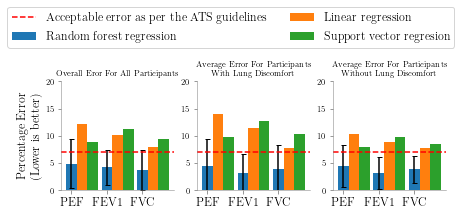

In [6]:
# plots to be manullly made using results from sheet
#Cloth Mask

rf_pe= [4.86,4.20,3.67]
lr_pe = [12.25,10.15,7.86]
svr_pe = [8.89,11.24,9.45]

rf_pe_h= [4.98,4.97,3.04]
lr_pe_h = [10.33,8.85,7.76]
svr_pe_h = [7.87,9.71,8.42]

rf_pe_u= [4.52,3.15,3.81]
lr_pe_u = [14.10,11.35,7.80]
svr_pe_u = [9.86,12.74,10.41]






rf_std= [4.52,3.27,3.71]
lr_std = [5.3,2.21,3.57]
svr_std = [6.62,4.51,4.21]

rf_pe_h_std= [3.85,2.98,2.47]
#lr_pe_h_std = [7.3,8.85,5.85]
#svr_pe_h_std = [5.85,9.75,4.55]

rf_pe_u_std= [4.95,3.48,4.54]
#lr_pe_u_std = [7.3,8.85,5.85]
#svr_pe_u_std = [5.85,9.75,4.55]


figname = 'revised-overall-error-cloth'
lt.latexify(columns=2, fig_height=2)
labels = ['PEF', 'FEV1', 'FVC']


x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(1,3)

rects1 = ax[0].bar(x, rf_pe, width, label='Random Forest', yerr=rf_std, ecolor='black', capsize=2.5, align='center')
rects2 = ax[0].bar(x + width, lr_pe, width, label='Linear Regression', ecolor='black', capsize=2.5, align='center')
rects3 = ax[0].bar(x + width*2, svr_pe, width, label='Support Vector Regressor', ecolor='black', capsize=2.5, align='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_title("Overall Eror For All Participants")
ax[0].set_ylabel('Percentage Error\n (Lower is better)',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, fontsize=12)
ax[0].set_ylim(0,20)
ax[0].axhline(y=7.00, color='r', linestyle='dashed')
#ax[0].annotate(' Result For N95 Mask',xy=(0, 0), xytext=(60, 190),xycoords=('axes fraction', 'axes fraction'),textcoords='offset points',size=14, ha='center', va='bottom', weight='bold')
#ax[0].legend(bbox_to_anchor=[0.55,1.2],ncol=3, fontsize=12, loc='center')
lt.format_axes(ax[0])

rects1 = ax[1].bar(x, rf_pe_u, width, label='Random Forest', yerr=rf_pe_u_std, ecolor='black', capsize=2.5, align='center')
rects2 = ax[1].bar(x + width, lr_pe_u, width, label='Linear Regression', ecolor='black', capsize=2.5, align='center')
rects3 = ax[1].bar(x + width*2, svr_pe_u, width, label='Support Vector Regressor',  ecolor='black', capsize=2.5, align='center')
ax[1].set_title("Average Error For Participants\n With Lung Discomfort")
#ax[1].set_ylabel('Percentage Error',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, fontsize=12)
ax[1].set_ylim(0,20)
ax[1].axhline(y=7.00, color='r', linestyle='dashed')
ax[1].legend(['Acceptable error as per the ATS guidelines','Random forest regression','Linear regression','Support vector regresion'],bbox_to_anchor=[0.3,1.5],ncol=2, fontsize=12, loc='center')
lt.format_axes(ax[1])


rects1 = ax[2].bar(x, rf_pe_u, width, label='Random Forest', yerr=rf_pe_h_std, ecolor='black', capsize=2.5, align='center')
rects2 = ax[2].bar(x + width, lr_pe_h, width, label='Linear Regression', ecolor='black', capsize=2.5, align='center')
rects3 = ax[2].bar(x + width*2, svr_pe_h, width, label='Support Vector Regressor',  ecolor='black', capsize=2.5, align='center')
ax[2].set_title("Average Error For Participants \nWithout Lung Discomfort")
#ax[1].set_ylabel('Percentage Error',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels, fontsize=12)
ax[2].set_ylim(0,20)
ax[2].axhline(y=7.00, color='r', linestyle='dashed')
lt.format_axes(ax[2])




#fig.tight_layout()




plt.savefig(figname+'.pdf', bbox_inches='tight')

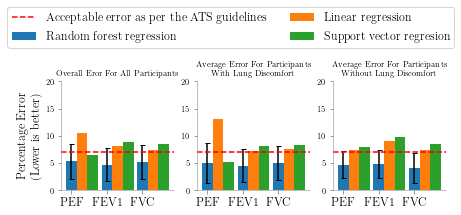

In [4]:
# plots to be manullly made using results from sheet
#N95 Mask

rf_pe= [5.30,4.72,5.11]
lr_pe = [10.45,8.19,7.47]
svr_pe = [6.52,8.95,8.47]

rf_pe_h= [4.66,4.75,4.11]
lr_pe_h = [7.35,9.12,7.33]
svr_pe_h = [7.87,9.71,8.42]

rf_pe_u= [4.98,4.50,5.01]
lr_pe_u = [13.15,7.12,7.55]
svr_pe_u = [5.15,8.19,8.28]

rf_std= [3.18,3.05,3.13]
#lr_std = [6.3,3.11,2.15]
#svr_std = [7.12,5.77,4.24]

rf_pe_h_std= [2.51,2.56,2.81]
#lr_pe_h_std = [7.3,8.85,5.85]
#svr_pe_h_std = [5.85,9.75,4.55]

rf_pe_u_std= [3.72,3.01,3.11]
#lr_pe_u_std = [7.3,8.85,5.85]
#svr_pe_u_std = [5.85,9.75,4.55]


figname = 'revised-overall-error-n95'
lt.latexify(columns=2, fig_height=2)
labels = ['PEF', 'FEV1', 'FVC']


x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(1,3)

rects1 = ax[0].bar(x, rf_pe, width, label='Random Forest', yerr=rf_std, ecolor='black', capsize=2.5, align='center')
rects2 = ax[0].bar(x + width, lr_pe, width, label='Linear Regression', ecolor='black', capsize=2.5, align='center')
rects3 = ax[0].bar(x + width*2, svr_pe, width, label='Support Vector Regressor', ecolor='black', capsize=2.5, align='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_title("Overall Eror For All Participants")
ax[0].set_ylabel('Percentage Error\n (Lower is better)',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, fontsize=12)
ax[0].set_ylim(0,20)
ax[0].axhline(y=7.00, color='r', linestyle='dashed')
#ax[0].annotate(' Result For N95 Mask',xy=(0, 0), xytext=(60, 190),xycoords=('axes fraction', 'axes fraction'),textcoords='offset points',size=14, ha='center', va='bottom', weight='bold')
#ax[0].legend(bbox_to_anchor=[0.55,1.2],ncol=3, fontsize=12, loc='center')
lt.format_axes(ax[0])

rects1 = ax[1].bar(x, rf_pe_u, width, label='Random Forest', yerr=rf_pe_u_std, ecolor='black', capsize=2.5, align='center')
rects2 = ax[1].bar(x + width, lr_pe_u, width, label='Linear Regression', ecolor='black', capsize=2.5, align='center')
rects3 = ax[1].bar(x + width*2, svr_pe_u, width, label='Support Vector Regressor',  ecolor='black', capsize=2.5, align='center')
ax[1].set_title("Average Error For Participants\n With Lung Discomfort")
#ax[1].set_ylabel('Percentage Error',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, fontsize=12)
ax[1].set_ylim(0,20)
ax[1].axhline(y=7.00, color='r', linestyle='dashed')
ax[1].legend(['Acceptable error as per the ATS guidelines','Random forest regression','Linear regression','Support vector regresion'],bbox_to_anchor=[0.3,1.5],ncol=2, fontsize=12, loc='center')
lt.format_axes(ax[1])


rects1 = ax[2].bar(x, rf_pe_h, width, label='Random Forest', yerr=rf_pe_h_std, ecolor='black', capsize=2.5, align='center')
rects2 = ax[2].bar(x + width, lr_pe_h, width, label='Linear Regression', ecolor='black', capsize=2.5, align='center')
rects3 = ax[2].bar(x + width*2, svr_pe_h, width, label='Support Vector Regressor',  ecolor='black', capsize=2.5, align='center')
ax[2].set_title("Average Error For Participants \nWithout Lung Discomfort")
#ax[1].set_ylabel('Percentage Error',fontsize=12)
#ax.set_title('Percentage Error For Differnet Type of Mask', fontsize=12)
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels, fontsize=12)
ax[2].set_ylim(0,20)
ax[2].axhline(y=7.00, color='r', linestyle='dashed')
lt.format_axes(ax[2])




#fig.tight_layout()




plt.savefig(figname+'.pdf', bbox_inches='tight')

## Accuracy vs Sampling Rate

C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


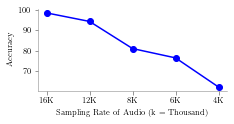

In [2]:
#data from edge impulse studio
figname="sampling-accuracy"
lt.latexify(columns=1, fig_height=1.5)
samplingRates = ['16K', '12K','8K','6K','4K']
accuracy = [98.47, 94.32, 81.13, 76.6, 62.43]
#loss = [0.04,0.12,0.18,0.27,0.30,0.40]
fig, ax = plt.subplots(1,1)
ax.plot(samplingRates, accuracy,'bo-')
ax.set_xlabel('Sampling Rate of Audio (k = Thousand)')
ax.set_ylabel('Accuracy')
lt.format_axes(ax)
plt.savefig(figname+'.pdf', bbox_inches='tight')

In [4]:
lt.latexify?